In [17]:
# section 1 load all the necessary modules and packages
import glob
import time
import geopandas as gpd
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon
# not neccessary for the function but for visualization
import matplotlib.pyplot as plt
import warnings
import sys
import networkx as nx


# defining the most downstream river segment and lakes

In [18]:
# define the target river segment
target_segment = 71021602 # segment that passes Saskatoon

# load merti hydro river and catchments
input_river = '/Users/shg096/Desktop/MERIT_Hydro/riv/riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
input_cat   = '/Users/shg096/Desktop/MERIT_Hydro/cat_final/cat_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1_fixed.shp'



# Subset the river segment for a given outlet for MERIT hydro
## South Saskatchewan River in Saskatoon

the element of the upstream segments and catchemtns do no match


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

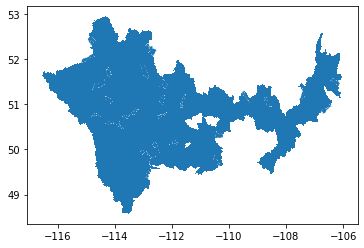

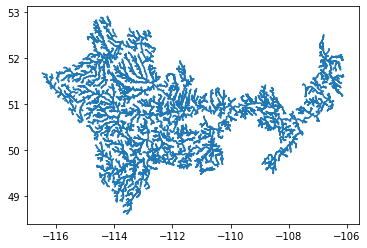

In [19]:

# load the files and calculating the downstream of each segment
riv  = gpd.read_file(input_river)
cat  = gpd.read_file(input_cat)

# get all the upstream
# create the riv graph
riv_graph = nx.from_pandas_edgelist(riv,\
                                    source='COMID',\
                                    target='NextDownID',\
                                    create_using=nx.DiGraph)
nodes = nx.ancestors(riv_graph, target_segment)
nodes = np.array(list(nodes))
nodes = np.append(nodes, target_segment)


# subset
cat_up = cat.loc[cat['COMID'].isin(nodes)]
riv_up = riv.loc[riv['COMID'].isin(nodes)]
# plotting
cat_up.plot()
riv_up.plot()

# check the length
if len(cat_up) == len(riv_up):
    print('the element of the upstream segments and catchemtns do no match')
# saving
cat_up['cat_area'] = 0
cat_up['cat_id'] = 0
cat_up['cat_area'] = cat_up['unitarea'].values * 1000000 # km2 to m2
cat_up['cat_id'] = cat_up['COMID'].values # cat_id
cat_up = cat_up.drop(columns=['unitarea', 'COMID']) # drop COMID and unitarea
cat_up.to_file('../data/shp/cat_'+str(target_segment)+'_merit.shp')
# saving river
riv_up['length']    = riv_up['lengthkm'] * 1000 # km to m
riv_up['seg_id']    = riv_up['COMID'] # COMID to seg_id
riv_up['to_seg_id'] = riv_up['NextDownID'] # NextDownID to to_seg_id
riv_up['uparea']    = riv_up['uparea'] * 1000000 # km2 to m2
idx = riv_up.index[riv_up['seg_id']==target_segment]
# down ID is not in the seg_id
riv_up['to_seg_id'].loc[idx] = -9999 # this should be more general, -9999 for all the points where the 
riv_up.to_file('../data/shp/riv_'+str(target_segment)+'_merit.shp')



## subset the hydrolake based on the bounding box of the catchments

In [20]:
# read the hydrolakes shapefile
lake = gpd.read_file('/Volumes/F:/hydrography/hydrolakes/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp')
cat_up = gpd.read_file('../data/shp/cat_'+str(target_segment)+'_merit.shp')
lake['lake_id'] = lake['Hylak_id'] # lake ID
lake['Lake_area'] = lake['Lake_area'] * 1000000 # km2 to m2
lake['lake_vol'] = lake['Vol_total'] * 1000000 # million m3 to m3
lake = lake.rename(columns={'Lake_area':'lake_area'})
lake['x'] = lake.centroid.x # add centroid lon
lake['y'] = lake.centroid.y # add centroid lat
# boundaries
min_lon, min_lat, max_lon, max_lat = cat_up.total_bounds
min_lon, min_lat, max_lon, max_lat = min_lon-2, min_lat-2, max_lon+2, max_lat+2 # add two degree buffer
# subset lake
lake_subset = lake
lake_subset = lake_subset[lake_subset['x']<max_lon]
lake_subset = lake_subset[lake_subset['x']>min_lon]
lake_subset = lake_subset[lake_subset['y']<max_lat]
lake_subset = lake_subset[lake_subset['y']>min_lat]
lake_subset.to_file('../data/shp/lake_'+str(target_segment)+'_merit.shp')



/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_25797/492103094.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lake['x'] = lake.centroid.x # add centroid lon
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_25797/492103094.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lake['y'] = lake.centroid.y # add centroid lat


## intersection of river segment and lakes

In [21]:
lake = gpd.read_file('../data/shp/lake_'+str(target_segment)+'_merit.shp')
riv_up = gpd.read_file('../data/shp/riv_'+str(target_segment)+'_merit.shp')
river_int_lake = gpd.overlay(riv_up, lake, how = 'intersection')
river_int_lake.to_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')



# check if the intersection seg_id has unique lake_id
## otherwise dissolving is needed for seg_id and lake_id

In [22]:
# read the intersected shapefile of river network and 
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
not_unique = False

for i in np.unique(shp['seg_id']):
    shp_sub = shp[shp['seg_id'] == i] # subset the river segment elements
    if len(np.unique(shp_sub['lake_id'])) != len(shp_sub['lake_id']): # segment intersect with more than 1 lake
        not_unique = True

# reporting
if not_unique:
    print('it seems there are less seg_id that elements of the river and lake intersection;')
    print('river and lake intersection should be dissolved on seg_id and lake_id')
else:
    print('it seems there is one seg_id for each element of the river and lake intersection')



it seems there is one seg_id for each element of the river and lake intersection


# Check the number of lakes that a segment is interseting with

In [23]:
# read the intersected shapefile of river network and 
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
print('Number of lakes in the intersection:',len(np.unique(shp['lake_id'])))
m = 0
for i in np.unique(shp['seg_id']):
    shp_sub = shp[shp['seg_id'] == i] # subset the river segment elements
    if len(np.unique(shp_sub['lake_id'])) > 1: # segment intersect with more than 1 lake
        m = m + 1 # counter
#         print(i) # print the segment ID
#         print('number of lakes: ',len(np.unique(shp_sub['lake_id']))) # print the number of lake
#         print('number of lakes: ',(np.unique(shp_sub['lake_id']))) # print lake ID
#         print('----')
# num seg intersecting with more than 1 lake
print('number of river segments that intersect with more than one lake :', m)



Number of lakes in the intersection: 471
number of river segments that intersect with more than one lake : 124


# Simplify the intersection step 1

### Remove the smaller lakes for river segments that have more than one lake intersecting with them in the river_intersection_lake


In [24]:
# read the intersected shapefile of river network and 
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
lake_ID = np.unique(shp['lake_id']) # get the ID of the lakes in teh intersetion
print('Number of lakes in the original intersection:',len(np.unique(shp['lake_id'])))
shp['remove'] = 0 # initializing the remove field

# looping over the segments, and remove the multiple lakes based on the area
warnings.simplefilter('ignore') # silent the warning
for i in np.unique(shp['seg_id']):
    shp_sub = shp[shp['seg_id'] == i] # subset based on river segments
    if len(np.unique(shp_sub['lake_id'])) > 1: # segment intersect with more than 1 lake
        # print(i) # print segment ID
        shp_sub = shp_sub.sort_values(by = ['lake_area'], ascending=False) # sort based on lake area
        max_lake_area = shp_sub['lake_area'].max() # get the maximume lake area
        for index, row in shp_sub.iterrows():
            if shp['lake_area'].loc[index] != max_lake_area:
                shp['remove'].loc[index] = 1 # loop over the subset shapefile and remove lake with smaller area
warnings.simplefilter('default') # back to normal

shp = shp [shp['remove']==1] # remove lakes which are flagged to be removed
shp = shp.sort_values(by= 'seg_id') # sort based on seg_id
shp = shp.reset_index(drop=True) # reindex based on the new sorting

#get the lake ID of the removed object
lake_ID_remove = np.unique(shp['lake_id']) # the IDs that are removed
lake_ID_keep = np.setdiff1d(lake_ID, lake_ID_remove) # the IDs that should be kept

# subset the intersection based on the lake_ID that are kept
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
shp = shp[shp['lake_id'].isin(lake_ID_keep)] # subset the shapefile to IDs that are kept
print('Number of lakes in the simplified intersection:',len(np.unique(shp['lake_id']))) # print the number
shp.to_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp') # save to file



Number of lakes in the original intersection: 471
Number of lakes in the simplified intersection: 297


# Simplify the intersection step 2
### Remove the lakes that have only on river segment passing through them (unresolved lakes)

In [25]:
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp') # read from file
print('Number of lakes in the simplified intersection:',len(np.unique(shp['lake_id'])))
# remove the lakes that have only one river segment (unresolvabale lakes)
shp['keep'] = 1

# looping over lakes and take out the lake that has only one river segment 
warnings.simplefilter('ignore') # silent the warning
for i in np.unique(shp['lake_id']):
    # print(i)
    shp_sub = shp[shp['lake_id'] == i] # subset the river segment inside a lake
    if len(np.unique(shp_sub['seg_id'])) == 1:
        indx = shp_sub.index
        shp['keep'].loc[indx] = 0
warnings.simplefilter('default') # back to normal

shp = shp [shp['keep']==1]
shp = shp.sort_values(by= 'seg_id')
shp = shp.reset_index(drop=True)

print('Number of lakes in the simplified intersection:',len(np.unique(shp['lake_id'])))
shp.to_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp') # save to file



Number of lakes in the simplified intersection: 297
Number of lakes in the simplified intersection: 70


# Check the simplified result
### To reassure that the simplified intersection has one lake per segment

In [26]:
# read the intersected shapefile of river network and 
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
print('Number of lakes in the intersection:',len(np.unique(shp['lake_id'])))
m = 0
for i in np.unique(shp['seg_id']):
    shp_sub = shp[shp['seg_id'] == i] # subset the river segment elements
    if len(np.unique(shp_sub['lake_id'])) > 1: # segment intersect with more than 1 lake
        m = m + 1 # counter
        print(i) # print the segment ID
        print('number of lakes: ',len(np.unique(shp_sub['lake_id']))) # print the number of lake
        print('number of lakes: ',(np.unique(shp_sub['lake_id']))) # print lake ID
        print('----')
# num seg intersecting with more than 1 lake
print('number of river segments that intersect with more than one lake :', m)
if m == 0:
    print('good to continue')
else:
    print('sth is wrong! the number of lake river intersection')



Number of lakes in the intersection: 70
number of river segments that intersect with more than one lake : 0
good to continue


# check if the intersection seg_id has unique lake_id
## otherwise dissolving is needed for seg_id and lake_id

In [27]:
# read the intersected shapefile of river network and 
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
not_unique = False

for i in np.unique(shp['seg_id']):
    shp_sub = shp[shp['seg_id'] == i] # subset the river segment elements
    if len(np.unique(shp_sub['lake_id'])) != len(shp_sub['lake_id']): # segment intersect with more than 1 lake
        not_unique = True

# reporting
if not_unique:
    print('it seems there are less seg_id that elements of the river and lake intersection;')
    print('river and lake intersection should be dissolved on seg_id and lake_id')
else:
    print('it seems there is one seg_id for each element of the river and lake intersection')
    print('good to go')




it seems there is one seg_id for each element of the river and lake intersection
good to go


# resolved lakes

In [28]:
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
lake = gpd.read_file('../data/shp/lake_'+str(target_segment)+'_merit.shp')
resolved_lake_id = np.unique(shp['lake_id'])
lake_resolved = lake[lake['lake_id'].isin(resolved_lake_id)]
lake_resolved.to_file('../data/shp/resolved_lake_'+str(target_segment)+'_merit.shp')


# identify the outflow and inflow for the river segments


In [29]:
shp = gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')

shp ['inflow'] = 1
shp ['outflow'] = 0

warnings.simplefilter('ignore') # silent the warning
for i in np.unique(shp['lake_id']):
    # print(i)
    shp_sub = shp[shp['lake_id'] == i] # subset the river segment inside a lake
    max_area = shp_sub['uparea'].max()
    indexs = shp_sub.index
    for index in indexs:
        if (shp_sub['uparea'].loc[index] == max_area) and (shp_sub['to_seg_id'].loc[index] > 0):
            shp ['inflow'].loc[index] = 0
            shp ['outflow'].loc[index] = 1
warnings.simplefilter('default') # silent the warning

shp.to_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')



# Correct the length based on what is under the lake
### Here the length is corrected for the segments that have a link with the lake (the simplified version)

In [30]:
riv_lake =  gpd.read_file('../data/shp/riv_lake_'+str(target_segment)+'_merit.shp')
riv      =  gpd.read_file('../data/shp/riv_'+str(target_segment)+'_merit.shp')

# reproect to meter projection and prepare the field to allocated
riv_lake_temp = riv_lake.to_crs ("EPSG:6933") # project to equal area
riv_lake ['length_lake'] = riv_lake_temp.length
riv_lake = riv_lake.sort_values(by='seg_id')
riv_lake = riv_lake.reset_index(drop=True)

# riv length_ratio and subset for riv_lake_simplified
riv_temp = riv.to_crs ("EPSG:6933")
riv['length_bef'] = riv_temp.length
riv_sub = riv[riv['seg_id'].isin(np.array(riv_lake['seg_id']))]
riv_sub = riv_sub.sort_values(by='seg_id')
riv_sub = riv_sub.reset_index(drop=True)

# riv 
riv_sub['len_ratio'] = 1.00 - (riv_lake['length_lake']/riv_sub['length_bef'])
riv_sub['inflow'] = riv_lake['inflow']
riv_sub['outflow'] = riv_lake['outflow']
riv_sub['lake_id'] = riv_lake['lake_id']

# default values
riv['len_ratio'] = 1.00
riv['inflow'] = -1.00
riv['outflow'] = -1.00
riv['lake_id'] = -1.00
# pass the values to the riv shapefile
indx = riv.index[riv['seg_id'].isin(riv_sub['seg_id'])]
riv['len_ratio'].loc[indx] = np.array(riv_sub['len_ratio'])
riv['inflow'].loc[indx] = np.array(riv_sub['inflow'])
riv['outflow'].loc[indx] = np.array(riv_sub['outflow'])
riv['lake_id'].loc[indx] = np.array(riv_sub['lake_id'])

riv.to_file('../data/shp/riv_lake_length_corrected_'+str(target_segment)+'_merit.shp')



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# correcting the subbasins for lakes and find their area ratio

In [31]:
lakes = gpd.read_file('../data/shp/resolved_lake_'+str(target_segment)+'_merit.shp')
basins = gpd.read_file('../data/shp/cat_'+str(target_segment)+'_merit.shp')

# calculate the area of cat with equal area
basins_temp = basins.to_crs("EPSG:6933")
basins ['area_bef'] = basins_temp.area # calculated area before correction

# correcting the basins based on the lakes
basin_corrected = gpd.overlay(basins,lakes, how='difference')

# calculate the area of cat after lake correction
basin_corrected_temp = basin_corrected.to_crs ("EPSG:6933")
basin_corrected['area_aft'] = basin_corrected_temp.area # caclualted area after correction

# calculate area_ratio and corrected area
basin_corrected['area_ratio'] = basin_corrected['area_aft']/basin_corrected['area_bef']
basin_corrected = basin_corrected.drop(columns=['area_bef', 'area_aft'])
basin_corrected ['is_lake'] = 0.00

# make lake the same units as the 
lakes ['cat_area'] = lakes ['lake_area']
lakes ['cat_id'] = lakes ['lake_id']
lakes ['is_lake'] = 1.00
lakes ['area_ratio'] = 1.00

basin_corrected = basin_corrected.append(lakes)

basin_corrected = basin_corrected.filter(['cat_area','cat_id','is_lake','area_ratio','geometry'])

basin_corrected.to_file('../data/shp/cat_lake_area_corrected_'+str(target_segment)+'_merit.shp')
